<a href="https://colab.research.google.com/gist/soukainaRhazzafe/2d992a0f6a939378ead78c8e7b711c73/workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Regrression:

# I. EDA:

## 1. Importing librairies:

In [ ]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, auc, accuracy_score, precision_recall_fscore_support,roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

## 2. Importing the dataset:

In [ ]:
insurance = pd.read_csv('insurance.csv')
insurance

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075
...,...,...,...,...,...,...,...
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240


## 3. Info about the columns:

In [ ]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 4. Changing columns types to numerical:

In [ ]:
numerical_cols= ['age','bmi','children','insurance_cost']
for col in numerical_cols:
    insurance[col] = pd.to_numeric(insurance[col], errors='coerce')

## 5. Checking for duplicates:

In [ ]:
insurance.duplicated().sum()

1

### There is one duplicated row that should be removed.

## 6. Checking for missing values:

In [ ]:
insurance.isnull().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

### There are no missimg values from the dataset.

## 7. Some visualizations:

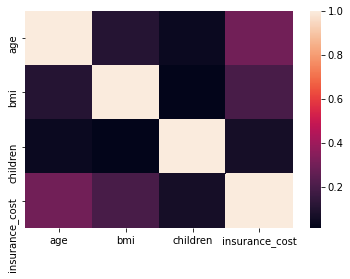

In [ ]:
sns.heatmap(insurance.corr());

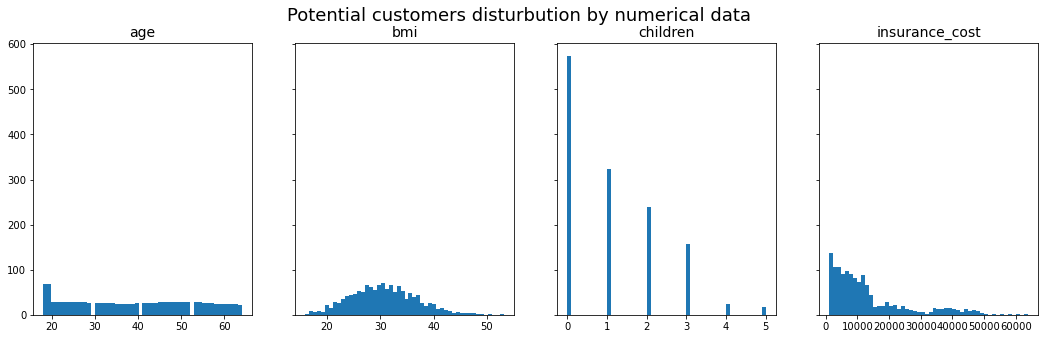

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(18,5), sharey=True)
axes = axes.ravel()

for ax, x in zip(axes, numerical_cols):
    ax.hist(insurance[x],  bins=50)
    ax.set_title(x, fontsize=14)


fig.suptitle('Potential customers disturbution by numerical data', fontsize=18)
plt.show()

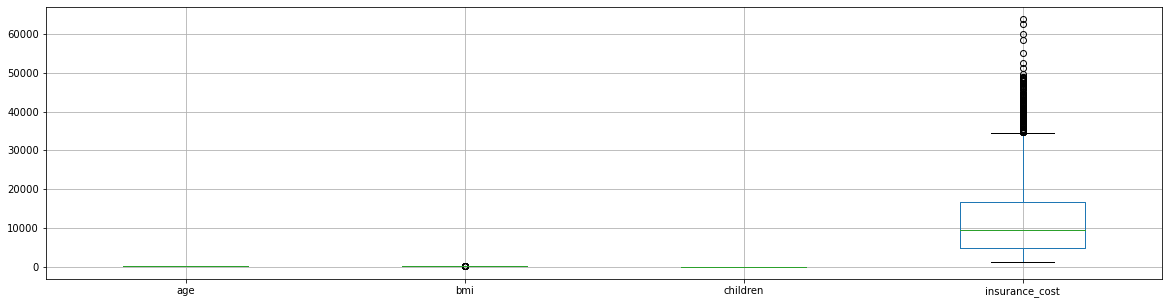

In [ ]:
insurance.loc[:,:].boxplot(figsize=(20,5))
plt.show()

### No severe outliers were found.

# II. Data Preparation:

## 1. Splitting the dataset:

In [ ]:
y = insurance['insurance_cost']
X = insurance.drop('insurance_cost', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, )

## 2. Preprocessing pipeline:

In [ ]:
categorical_cols=['gender','smoker','region']

category_transformer = ColumnTransformer([
    ("min_max_scaler",StandardScaler(),[0,2,3]),

    ("brand_location_ohe",ce.OneHotEncoder(handle_unknown='ignore'),[1,4,5]),
],remainder='passthrough')

## 3. Models' training:

### Linear Regression:

In [ ]:
pipe = Pipeline(steps=[('preprocess',category_transformer),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.744:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=11), 'reduce_dim__n_components': 11, 'regresson__normalize': False}


C:\Users\PC\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


### Random Forest Regressor:

In [ ]:
pipe = Pipeline(steps=[('preprocess', category_transformer),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.864:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


### KNN Regressor:

In [ ]:
pipe = Pipeline(steps=[('preprocess', category_transformer),
                       ('reduce_dim', 'passthrough'),
                       ('regresson',KNeighborsRegressor())])
N_FEATURES_OPTIONS = [2, 6, 11]
k_range = list(range(1, 31))
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': k_range

    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': k_range

    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.832:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__n_neighbors': 9}


## 4. Models evaluation:

In [ ]:
def evaluate_model(X_test, y_test, model):

    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)

    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse,KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)

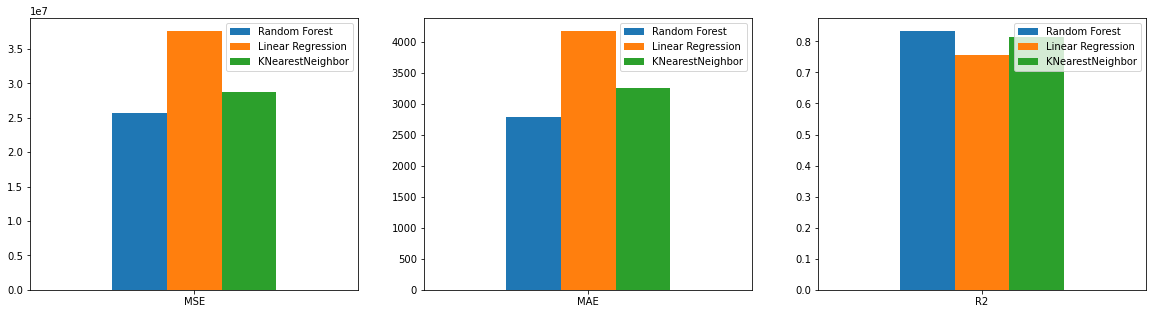

In [ ]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'KNearestNeighbor': KNN_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'KNearestNeighbor': KNN_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNearestNeighbor': KNN_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## The overall best model is the random forest.

## 5. Saving the best model:

In [ ]:
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

encoder=encoder=ce.OneHotEncoder(handle_unknown='ignore',use_cat_names=True)
preprocess_pipeline = make_pipeline(encoder,StandardScaler())


pipe = make_pipeline(preprocess_pipeline,
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)
filename = 'regressionl_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Classification:

## 1. Regression problem ta a classification problem:

In [ ]:
insurance.loc[insurance['insurance_cost'] < insurance['insurance_cost'].mean(), 'insurance_cost']= 0
insurance.loc[insurance['insurance_cost'] >= insurance['insurance_cost'].mean(), 'insurance_cost']= 1
insurance

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,0.0
1,18,male,34.100,0,no,southeast,0.0
2,18,female,26.315,0,no,northeast,0.0
3,18,female,38.665,2,no,northeast,0.0
4,18,female,35.625,0,no,northeast,0.0
...,...,...,...,...,...,...,...
1333,64,female,31.825,2,no,northeast,1.0
1334,64,female,26.885,0,yes,northwest,1.0
1335,64,male,26.410,0,no,northeast,1.0
1336,64,male,36.960,2,yes,southeast,1.0


## 2. Customers count by class:

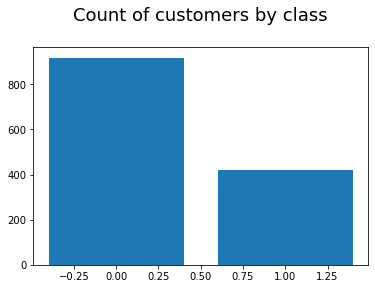

In [ ]:
plt.bar(insurance['insurance_cost'].unique(), insurance['insurance_cost'].value_counts())
plt.title('Count of customers by class\n', fontsize=18)
plt.show()

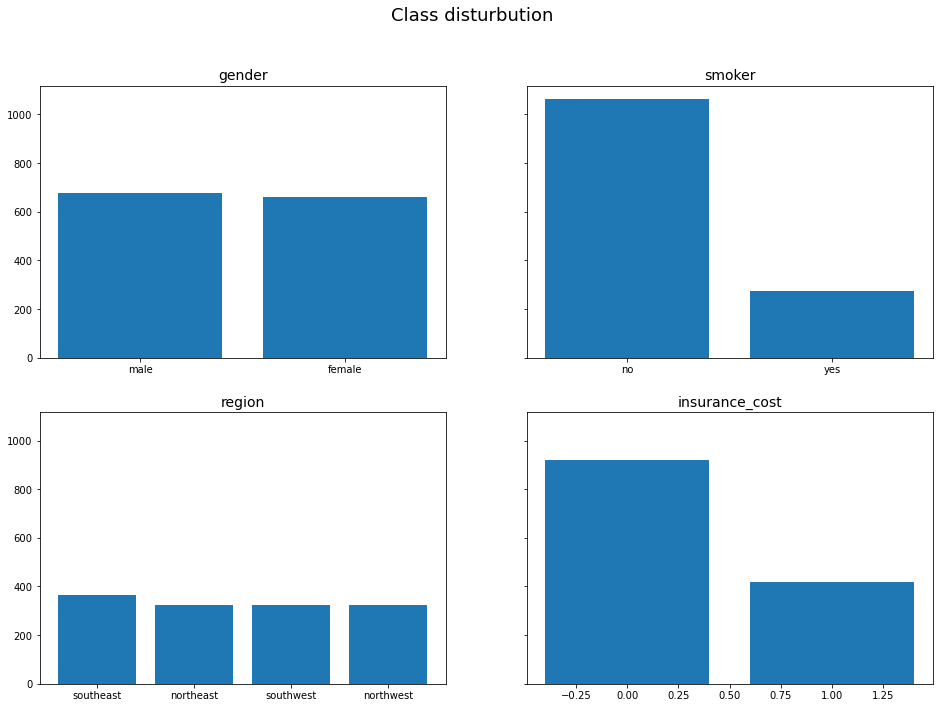

In [ ]:
columns = ['gender', 'smoker', 'region', 'insurance_cost']
fig, axes = plt.subplots(2,2,figsize=(16, 11), sharey=True)
axes = axes.ravel()


for ax, x in zip(axes, columns):
    ax.bar(insurance[x].unique(),insurance[x].value_counts())
    ax.set_title(x, fontsize=14)

fig.suptitle('Class disturbution', fontsize=18)
plt.show()

## 3. Attributes correlation to class:

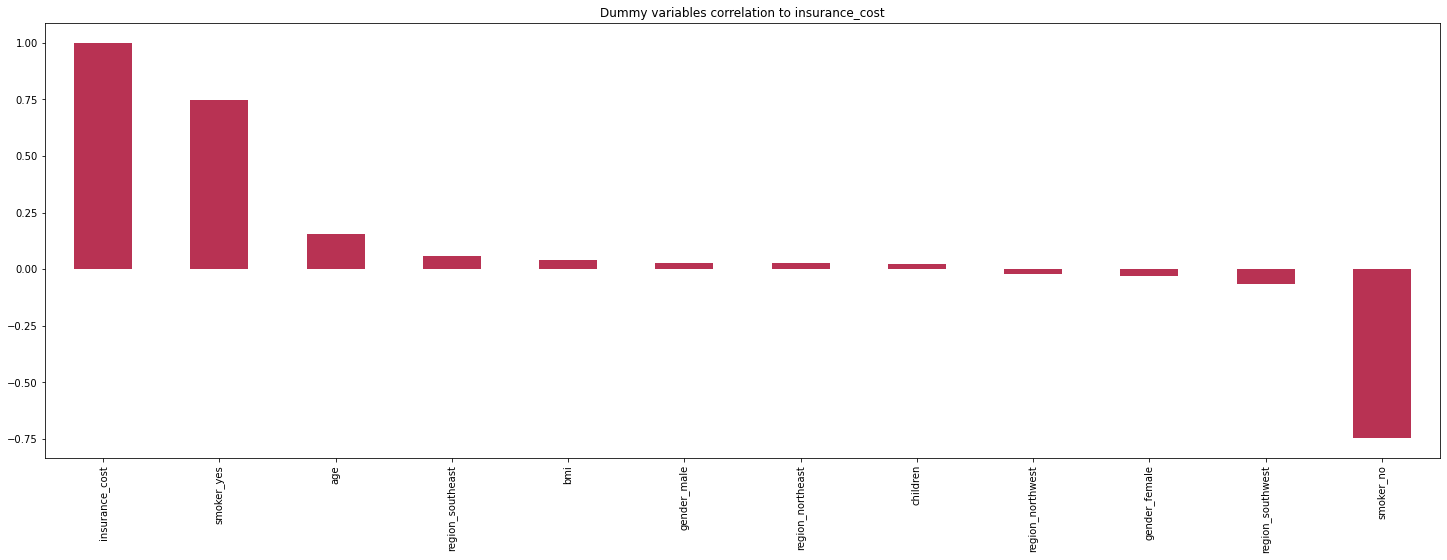

In [ ]:
dummies = pd.get_dummies(insurance)
plt.figure(figsize=(25,8))
dummies.corr()["insurance_cost"].sort_values(ascending = False).plot(kind='bar',color=['#b83253'])
plt.title('Dummy variables correlation to insurance_cost')
plt.show()

### We can remove the column gender since both its values seem to have very little correlation to the customer's choice.

# II. Data Preparation:

## 1. Splitting the dataset:

In [ ]:
y = insurance['insurance_cost']
X = insurance.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## 2. Models Training:

### SVM Classifier:

In [ ]:
pipe = Pipeline(steps=[('preprocess', category_transformer), ('svm', svm.SVC(probability=True))])
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.910:
Best parameters:  {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'poly'}


### RandomForest Classifier:

In [ ]:
pipe = Pipeline(steps=[('preprocess', category_transformer), ('rf', RandomForestClassifier())])
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.921:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 20}


### MLP Classifier:

In [ ]:
pipe = Pipeline(steps=[('preprocess', category_transformer), ('mlp', MLPClassifier())])
param_grid = {
    'mlp__max_iter': [300],
    'mlp__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate': ['constant','adaptive']
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.918:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (10, 30, 10), 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 300, 'mlp__solver': 'adam'}


C:\Users\PC\Documents\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


## 3. Models evaluation:

In [ ]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    _auc = auc(_fpr, _tpr)
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [ ]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

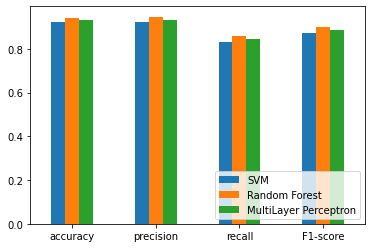

In [ ]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MultiLayer Perceptron': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

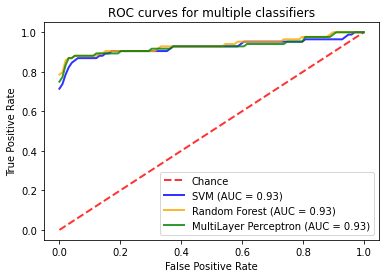

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MultiLayer Perceptron (AUC = %0.2f)' % (MLP_auc), alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

## 4. Training a model without the column 'gender':

In [ ]:
y = insurance['insurance_cost']
insurance = insurance.drop('gender',axis=1)
X = insurance.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

categorical_cols=['smoker','region']
encoder=encoder=ce.OneHotEncoder(handle_unknown='ignore',use_cat_names=True)
preprocess_pipeline = make_pipeline(encoder,StandardScaler())

category_transformer = ColumnTransformer([
    ("min_max_scaler",StandardScaler(),[0,1,2]),

    ("brand_location_ohe",ce.OneHotEncoder(handle_unknown='ignore'),[3,4]),
],remainder='passthrough')

pipe = Pipeline(steps=[('preprocess', category_transformer), ('rf', RandomForestClassifier())])
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.905:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 10}


In [ ]:
insurance

,age,bmi,children,smoker,region,insurance_cost
0,18,33.770,1,no,southeast,0.0
1,18,34.100,0,no,southeast,0.0
2,18,26.315,0,no,northeast,0.0
3,18,38.665,2,no,northeast,0.0
4,18,35.625,0,no,northeast,0.0
...,...,...,...,...,...,...
1333,64,31.825,2,no,northeast,1.0
1334,64,26.885,0,yes,northwest,1.0
1335,64,26.410,0,no,northeast,1.0
1336,64,36.960,2,yes,southeast,1.0


In [ ]:
def transform(dict):
    return {key.replace('rf__','') :  value for key, value in dict.items()}

pipe = make_pipeline(category_transformer, RandomForestClassifier(**transform(RF_best_params)))

final_model =pipe.fit(X, y)

plt.figure(figsize=(10,10))

X = pd.DataFrame(X, columns =['age', 'bmi', 'children', 'gender_female',
        'gender_male', 'smoker_no', 'smoker_yes', 'region_northeast',
        'region_northwest', 'region_southeast', 'region_southwest'])
sorted_columns = pipe.steps[1][1].feature_importances_.argsort()
plt_rf =plt.barh(X.columns[sorted_columns], pipe.steps[1][1].feature_importances_[sorted_columns],color='#fc666f')
plt.title('Feature importances ')

filename = 'Classification_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [ ]:
y_pred

array(['0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '1.0',
       '1.0'], dtype='<U32')

In [ ]:
DT = pickle.load(open('Classification_model.sav', 'rb'))
xv= X[:10]
yv= y[:10].astype(str)
print(DT)
y_pred = DT.predict(xv)

y_pred= y_pred.astype(str)
acc = accuracy_score(yv,y_pred)
print('Accuracy : ',acc)
print(classification_report(yv,y_pred))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  StandardScaler(), [0, 1, 2]),
                                                 ('brand_location_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [3, 4])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=2, n_estimators=10))])
Accuracy :  0.9
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10



*************************************************************************************

*********************************************************************************************************************

# Bank:

# I. EDA:

## 1. Importing librairies:

## 2. Importing the dataset:

In [ ]:
bank = pd.read_csv('bank.csv')

## 3. First look at the data:

In [ ]:
bank

### The dataset contains 2000 rows and 17 columns.

## 4. Info about the columns:

In [ ]:
bank.info()

### We can clearly see that there are some missing values:
- 'Age' contains 2000-1988 = 12 missing values.
- 'Job' contains 2000-1990 = 10 missing values.
- 'Education' contains 2000-1896 = 114 missing values.
- 'Contact' contains 2000-1809 = 191 missing values.
- 'POutcome' contains 2000-1546 = 454 missing values, less than 25% of data is missing so we can keep the column.

## 6. Checking for duplicates:

In [ ]:
bank.duplicated().sum()

### There are no duplicated rows in the dataset.

### We will deal with missing values later, as for now let's just drop rows containing missing values.

## 6. Numerical data exploration:

In [ ]:
bank.describe()

## 7. Attributes correlation to the target:

### Dataset encoding:

In [ ]:
bank['subscribed'] = bank['subscribed'].replace({'yes': 1, 'no': 0})
dummies = pd.get_dummies(bank.dropna())
dummies

In [ ]:
plt.figure(figsize=(25,8))
dummies.corr()["subscribed"].sort_values(ascending = False).plot(kind='bar',color=['#b83253'])
plt.title('Dummy variables correlation to subscription')
plt.show()

# II. Data Preparation: